<a href="https://colab.research.google.com/github/szymonrucinski/bert-knows-categories/blob/master/BertMultiLabelClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARINC Fingerprinting BERT Multi Labels Class Classifier

Since Huggingface only implemented single class classification (with loss function `CrossEntropyLoss` used), we need to modify a bit to use our own loss function (i.e. `BCEWithLogitsLoss`). 

Also, `sigmoid` is chosen instead of `softmax` at the final layer because it ensure multi-class availability.

For more details you can check [Transformer for Multi-Label](htt\**ps**://towardsdatascience.com/transformers-for-multilabel-classification-71a1a0daf5e1)


Import related libraries:

In [49]:

# !pip install transformers
# !pip install torch
# !pip install iterative-stratification

'''Train with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch.utils.data as data
from sklearn.metrics import accuracy_score, f1_score
# BERT Related Libraries
from transformers import BertTokenizer, BertForSequenceClassification
#ITERATIVE splitter
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import KFold
##Metrics
from sklearn.metrics import f1_score
# Python
import pandas as pd
import numpy as np
import os
import time
# from google.colab import drive
# drive.mount('/content/drive')
torch.cuda.empty_cache()

Declaring machine learning parameters:

In [50]:
# ML Parameters

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
model_name = 'bert-base-uncased'
model_name = 'dbmdz/bert-base-german-uncased'
epochs = 4
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kfold=KFold(n_splits=5,shuffle=True)

Data Source:

In [51]:
train_path = "/content/drive/MyDrive/dataset/features.csv"
labels_path = "/content/drive/MyDrive/dataset/labels.csv"

train_path = "./dirty_features.csv"
labels_path = "./labels.csv"
####
texts_df = pd.read_csv(train_path)
texts_df.drop(columns=['ProductId'],inplace=True)
texts_df.reset_index(inplace=True, drop=True)
texts_df.rename(columns = {'MarketingDescription_DE':'texts'}, inplace = True)

labels_df = pd.read_csv(labels_path)
labels_df.drop(columns=['ProductId'],inplace=True)
labels_df.reset_index(inplace=True, drop=True)



###6 classes only
top_classes = labels_df.sum(axis=0).sort_values(ascending=False)[:10].index
labels_df = labels_df[top_classes]


labels_df.iloc[labels_df[labels_df.sum(axis=1)==1].index]
texts_df.iloc[labels_df[labels_df.sum(axis=1)==1].index]




train_df = pd.concat([texts_df,labels_df],axis=1)

In [52]:
#Load kaggle

# texts_df = pd.read_csv('./toxic/train.csv')
# texts_df.rename(columns = {'comment_text':'texts'}, inplace = True)
# texts_df.drop(columns=['id'],inplace=True)
# labels_df = texts_df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']][:4000]
# texts_df = texts_df[['texts']][:4000]


In [53]:
# from pandas.core.dtypes.common import classes
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Define tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)


Create one data accessor (for PyTorch to read the data above easily):

395


(array([ 893., 1531., 1182.,  753.,  576.,  890.,  132.,   20.,    4.,
           2.]),
 array([  6. ,  44.9,  83.8, 122.7, 161.6, 200.5, 239.4, 278.3, 317.2,
        356.1, 395. ]),
 <BarContainer object of 10 artists>)

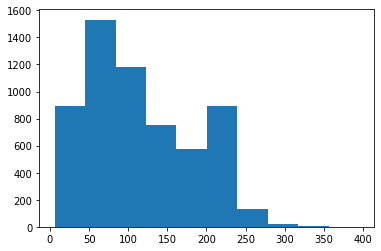

In [54]:
max_len = 0
distribution = []

for sent in texts_df.texts.values:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
    distribution.append(len(input_ids))
# Tokenize all of the sentences and map the tokens to thier word IDs.
print(max_len)

import matplotlib.pyplot as plt
plt.hist(distribution)


In [55]:
np.mean(distribution)

114.83202406819322

In [56]:
input_ids = []
attention_masks = []
# For every sentence...
for sent in texts_df.texts.values:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 200,           # Pad & truncate all sentences.
                        # truncation=True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels_df.to_numpy())
labels = labels.float()

# Print sentence 0, now as a list of IDs.
print('Original: ', texts_df.texts.iloc[0].lower())
print('Token IDs:', input_ids[0])

print('Original: ', texts_df.texts.iloc[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Szymon\anaconda3\envs\ds\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  die produktreihe mit netgear gigabit unmanaged switches gestattet unternehmen, ihre netzwerke auf gigabit-geschwindigkeit und höhere port-zahlen auszubauen. sie sind energiesparend, langlebig und unterliegen rigorosen tests zur gewährleistung der von unternehmen geforderten zuverlässigkeit. netgear unmanaged switches unterstützen ebenfalls den energy efficient ethernet standard, wodurch der energieverbrauch reduziert wird, wenn an einem aktiven port wenig datenverkehr herrscht oder keine links oder aktivitäten erkannt werden. auch durch die verwendung von kurzen kabeln kann energie gespart werden.
Token IDs: tensor([  102,   125,  3965,  8135,   183,  6043,   118,   137, 19498,  7092,
        30942,   126,  1148,   634, 30944,  4644, 27686,   131, 15174,  1091,
          806,   597, 21484,   193, 19498,  7092, 30942,   223,  8172,   143,
         7517, 30937,  2177,   223,  3576, 25295,   552,   208,   321,  2376,
        13624, 30944,   806,  1221, 14377,   209,   143, 1641

In [57]:
from transformers import AutoTokenizer

decoded_outputs = tokenizer.decode(input_ids[1])
decoded_outputs

'[CLS] hochwertiges flexibles patchkabel mit paar - und gesamtabschirmung, 8 adern twisted pair kupfer - litze, 4 x 2 x 0. 14mm2, kontaktbelegung 1 : 1 gemass eia / tia 568a, pimf, kat. 7 / klasse f [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

# Training validation split

In [58]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
train_index = []
test_index = []
valid_index = []
##SPLIT TO TRAIN AND TEST 
for train_index, test_index in msss.split(texts_df, labels_df):
       print("TRAIN:", train_index, "TEST:", test_index)
    #    x_train, x_test = texts_df.iloc[train_index], texts_df.iloc[test_index]
    #    y_train, y_test = labels_df.iloc[train_index], labels_df.iloc[test_index]
       train_index, test_index = train_index, test_index

TRAIN: [   1    2    3 ... 5980 5981 5982] TEST: [   0    8   14 ... 5967 5974 5979]


In [59]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.17, random_state=1)

for train_index, valid_index in msss.split(texts_df.iloc[train_index], labels_df.iloc[train_index]):
       print("TRAIN:", train_index, "VALID:", test_index)
       train_index, valid_index = train_index, valid_index

TRAIN: [   0    1    2 ... 4783 4784 4785] VALID: [   0    8   14 ... 5967 5974 5979]


In [60]:
print(len(train_index), len(test_index),len(valid_index))

3972 1197 814


In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [62]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids[train_index], attention_masks[train_index], labels[train_index])
test_dataset = TensorDataset(input_ids[test_index], attention_masks[test_index], labels[test_index])
valid_dataset = TensorDataset(input_ids[valid_index], attention_masks[valid_index], labels[valid_index])

In [63]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            valid_dataset, # The validation samples.
            sampler = SequentialSampler(valid_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [64]:
### MultiLabel classification

from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AutoModelForSequenceClassification, AutoConfig, BertForSequenceClassification

configuration = AutoConfig.from_pretrained(model_name)
configuration.hidden_dropout_prob = 0.3
configuration.num_labels = labels_df.shape[1]
configuration.problem_type="multi_label_classification"

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,
     # Use the 12-layer BERT model, with an uncased vocab.
         # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    # output_attentions = False, # Whether the model returns attentions weights.
    # output_hidden_states = False, # Whether the model returns all hidden-states.
    config = configuration,
)

Some weights of the model checkpoint at dbmdz/bert-base-german-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [65]:
# from transformers import BertModel

# class BERTClass(torch.nn.Module):
#     def __init__(self):
#         super(BERTClass, self).__init__()
#         self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
#         self.dropout = torch.nn.Dropout(0.3)
#         self.linear = torch.nn.Linear(768, labels_df.shape[1])
    
#     def forward(self, input_ids, attention_mask, token_type_ids):
#         output = self.bert_model(
#             input_ids, 
#             attention_mask=attention_mask, 
#             token_type_ids=token_type_ids
#         )
#         output_dropout = self.dropout(output.pooler_output)
#         output = self.linear(output_dropout)
#         return output

# model = BERTClass()
# model.to(device)

In [66]:
criterion = torch.nn.BCEWithLogitsLoss()

Prepare Data Training Set and Testing Set:

In [67]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)

# #Iterative split
# # x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.2,stratify=labels,random_state=1)
# msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
# for train_index, test_index in msss.split(texts_df, labels_df):
#        print("TRAIN:", train_index, "TEST:", test_index)
#        x_train, x_test = texts_df.iloc[train_index], texts_df.iloc[test_index]
#        y_train, y_test = labels_df.iloc[train_index], labels_df.iloc[test_index]



# ### Load split data in df
# trainData = pd.concat([x_train,y_train],axis=1)
# testData = pd.concat([x_test,y_test],axis=1)

# # trainData.reset_index(inplace=True)
# # testData.reset_index(inplace=True)

# # Load training dataset
# dataset = SentenceDataset(trainData)
# print("Total: %i" % len(dataset))

# # Load into Iterator (each time get one batch)
# # train_loader = data.DataLoader(trainData, batch_size=batch_size, shuffle=True,drop_last=False, num_workers=0)
# # test_loader = data.DataLoader(testData, batch_size=batch_size, shuffle=True,drop_last=False, num_workers=0)


## 4.2. Optimizer & Learning Rate Scheduler

In [68]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
)

from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

c:\Users\Szymon\anaconda3\envs\ds\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Metrics

In [69]:
import numpy as np

import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [70]:
# from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
# from transformers import EvalPrediction
# import torch

# def multi_label_metrics(predictions, labels, threshold=0.5):
#     # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
#     sigmoid = torch.nn.Sigmoid()
#     probs = sigmoid(torch.Tensor(predictions))
#     # next, use threshold to turn them into integer predictions
#     y_pred = np.zeros(probs.shape)
#     y_pred[np.where(probs >= threshold)] = 1
#     # finally, compute metrics
#     y_true = labels
#     f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
#     roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
#     accuracy = accuracy_score(y_true, y_pred)
#     # return as dictionary
#     metrics = {'f1': f1_micro_average,
#                'roc_auc': roc_auc,
#                'accuracy': accuracy}
#     return metrics

# def compute_metrics(p: EvalPrediction):
#     preds = p.predictions[0] if isinstance(p.predictions, 
#             tuple) else p.predictions
#     result = multi_label_metrics(
#         predictions=preds, 
#         labels=p.label_ids)
#     return result

In [71]:
model.to(device)

RuntimeError: CUDA out of memory. Tried to allocate 92.00 MiB (GPU 0; 6.00 GiB total capacity; 5.21 GiB already allocated; 0 bytes free; 5.30 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Training BERT

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss, logits = outputs['loss'], outputs['logits']


        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()
        
        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        
        #!!!!!!!!!!!!!!EDIT!!!!!!!!
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels, return_dict=True)
            
            loss, logits = outputs['loss'], outputs['logits']

            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        
        # total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    # avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    # print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            # 'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_index)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
pre_norm,predictions, true_labels = [], [],[]

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  
  logits = outputs.logits
  # THRESHOLD = 0.5
  # logits[logits > THRESHOLD] = 1
  # logits[logits <= THRESHOLD] = 0

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

In [ ]:
stacked_predictions = np.vstack(predictions)
y_true = np.vstack(true_labels)

In [ ]:
stacked_predictions

In [ ]:
activate = torch.nn.Sigmoid()
PREDICTIONS = activate(torch.Tensor(stacked_predictions))

THRESHOLD = 0.30
PREDICTIONS[PREDICTIONS > THRESHOLD] = 1
PREDICTIONS[PREDICTIONS <= THRESHOLD] = 0
PREDICTIONS = np.asanyarray(PREDICTIONS)

f1_mic = f1_score(y_true, PREDICTIONS, average='micro')
f1_mac = f1_score(y_true, PREDICTIONS, average='macro')
acc = accuracy_score(y_true,PREDICTIONS)
print(f1_mic, f1_mac, acc)

In [ ]:
df_stats = pd.DataFrame(training_stats)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()